In [ ]:
import cv2
import os
import mediapipe as mp

# Load image
path = os.path.expanduser('./ASL_Data/asl_alphabet_train/asl_alphabet_train/C/C90.jpg')
image = cv2.imread(path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.3)

# Process image
results = hands.process(image_rgb)

# Draw results
if results.multi_hand_landmarks:
    print(f"Detected {len(results.multi_hand_landmarks)} hand(s).")
    for hand_landmarks in results.multi_hand_landmarks:
        mp.solutions.drawing_utils.draw_landmarks(
            image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
else:
    print("No hands detected.")

# Show image
# cv2.imshow("Hand Detection", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

I0000 00:00:1746814305.852236 16585823 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2
W0000 00:00:1746814305.867356 16586968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746814305.880362 16586968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746814305.912492 16586972 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Detected 1 hand(s).


In [3]:
import pandas as pd
from collections import defaultdict
from mediapipe.framework.formats import landmark_pb2

hand_map = defaultdict(list)
for start_idx, end_idx in mp.solutions.hands.HAND_CONNECTIONS:
        hand_map[start_idx].append(end_idx)
        hand_map[end_idx].append(start_idx) 

def hand_connections_and_landmarks(results: landmark_pb2.NormalizedLandmarkList, connection_map: defaultdict) -> pd.DataFrame:
    # Build landmark rows with connected landmark indices
    landmark_rows = []
    for hand_idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
        for i, landmark in enumerate(hand_landmarks.landmark):
            landmark_rows.append({
                'hand_index': hand_idx,
                'landmark_index': i,
                'x': landmark.x,
                'y': 1 - landmark.y, # Invert y-axis for image coordinates
                'z': landmark.z,
                'connected_to': connection_map[i] 
            })
    return(pd.DataFrame(landmark_rows))

landmark_df = hand_connections_and_landmarks(results, hand_map)
print(landmark_df)

    hand_index  landmark_index         x         y             z connected_to
0            0               0  0.435843  0.379897  7.471014e-07   [5, 17, 1]
1            0               1  0.526281  0.368724 -6.853211e-03       [0, 2]
2            0               2  0.610731  0.394403 -1.460135e-02       [1, 3]
3            0               3  0.679940  0.421480 -2.591148e-02       [4, 2]
4            0               4  0.743312  0.433994 -3.664381e-02          [3]
5            0               5  0.559286  0.542781  2.057908e-02    [0, 6, 9]
6            0               6  0.637138  0.586208  7.659484e-03       [5, 7]
7            0               7  0.699129  0.597426 -1.027943e-02       [6, 8]
8            0               8  0.749581  0.597602 -2.327428e-02          [7]
9            0               9  0.548085  0.559950  9.494018e-03  [5, 10, 13]
10           0              10  0.632592  0.614467 -6.217313e-03      [9, 11]
11           0              11  0.701746  0.623812 -2.536473e-02

In [4]:
import torch
from torch_geometric.data import Data

def hand_graph(df: pd.DataFrame, label: int) -> Data:
    # Sort by landmark index to ensure node order
    df = df.sort_values('landmark_index')
    
    # Node features: x, y, z
    x = torch.tensor(df[['x', 'y', 'z']].values, dtype=torch.float)

    # Extract edges from `connected_to`
    edge_list = []
    for _, row in df.iterrows():
        src = row['landmark_index']
        for dst in row['connected_to']:
            edge_list.append((src, dst)) 

    # Ensure bidirectionality and remove duplicates
    edge_list += [(dst, src) for (src, dst) in edge_list]
    edge_list = list(set(edge_list))  # remove duplicates
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()  # [2, num_edges]

    # Label
    y = torch.tensor([label], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, y=y)


In [73]:
T_label = 19
graph_for_T = hand_graph(landmark_df, label=T_label)
graph_for_T

Data(x=[21, 3], edge_index=[2, 42], y=[1])

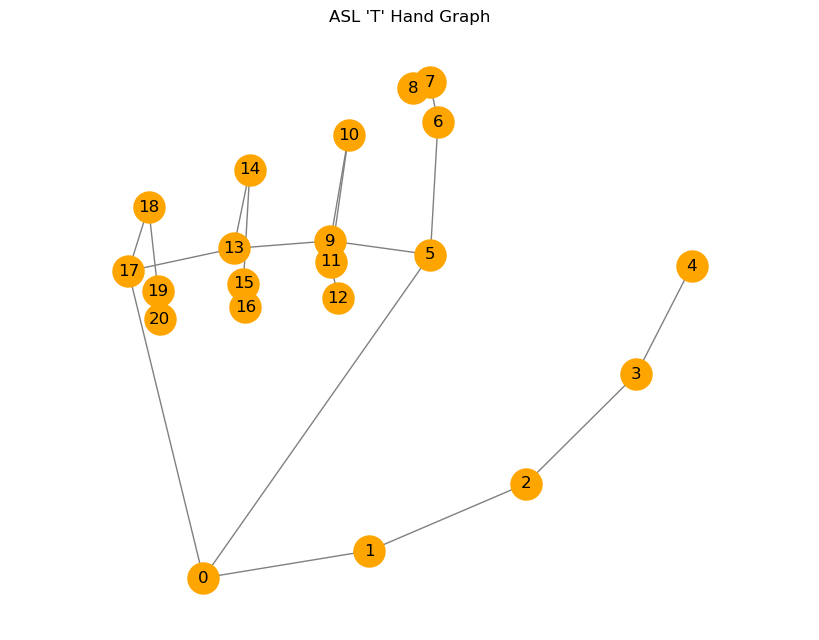

: 

In [ ]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

G = to_networkx(graph_for_T, to_undirected=True)
pos = {i: (graph_for_T.x[i][0].item(), graph_for_T.x[i][1].item()) for i in range(graph_for_T.num_nodes)}

plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='orange', edge_color='gray', node_size=500)
plt.title("ASL 'T' Hand Graph")
plt.axis('equal')
plt.show()

In [ ]:
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn as nn

class HandGNN(torch.nn.Module):
    def __init__(self, num_classes, dropout_rate=0.2, device='cpu'):
        super().__init__()
        self.conv1 = GCNConv(in_channels=3, out_channels=16, cached=True, improved=True)
        self.conv2 = GCNConv(in_channels=16, out_channels=32, cached=True, improved=True)
        self.lin = torch.nn.Linear(32, num_classes)
        self.dropout = torch.nn.Dropout(dropout_rate)

        self.train_loss_history = []
        self.val_loss_history = []

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = nn.ReLU()(x)
        x = self.conv2(x, edge_index)
        x = nn.ReLU()(x)
        x = global_mean_pool(x, batch)
        return self.lin(x)